## Subject set creation pipeline
This notebook demonstrates the pipeline used for creating the subject set. It includes the following codes:<br>
- get_images_from_url
- run_inference_graph_images
- load_image_into_numpy_array
- run_inference_for_single_image

These functions have to be arranged in modules so that it can be imported for further use. The modules with these functions are available [here](https://github.com/Manish-rai21bit/camera-trap-detection/tree/master/snapshot-safari)

This work is a streamlined version of [PredictAndEvaluate](https://github.com/Manish-rai21bit/camera-trap-detection/blob/master/training_demo/PredictAndEvaluation.ipynb)


### Running the inferrence detection can be done for bulk images
#running inference on the test images <br>
#SPLIT=validation  # or test <br>
TF\_RECORD\_FILES='/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/test_schneider.record' <br>
#OUTPUT\_TFR\_PATH ='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider.record' <br>
OUTPUT\_INFERENCE\_GRAPH='/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output\_inference\_graph/frozen\_inference\_graph.pb' <br>

python /home/ubuntu/data/tensorflow/models/research/object_detection/inference/infer_detections.py \ <br>
  --input\_tfrecord_paths=$TF\_RECORD\_FILES$ \ <br>
  --output\_tfrecord\_path='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider.record'\ 
  --inference\_graph=$OUTPUT\_INFERENCE\_GRAPH$ \ <br>
  --discard\_image\_pixels<br>


#Check the validity of Predictions

In [46]:
import numpy as np
import os, time
import six.moves.urllib as urllib
import sys, glob
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# Adding path to the utility functions
sys.path.append("/Users/manishrai/Desktop/UMN/Research/Zooniverse/Code/tensorflow/models/research")
from object_detection.utils import ops as utils_ops

# Importing the object detection utils
# from utils import label_map_util
# from utils import visualization_utils as vis_util

In [47]:
import urllib, urllib.request
import os, ssl
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# from run_inference_graph import load_image_into_numpy_array, run_inference_for_single_image

In [48]:
%matplotlib inline

In [13]:
"""The set of functions here will help in creating the subject set. 
Subject set creation for bounding box requires the following functions:
    get_images_from_url - Download the images from the url's given into a local path
    run_inference_graph_images on the downloaded images"""

def get_images_from_url(dataset, image_name_index, url_col_index, outpath):
    """This function takes in a dataframe and downloads the images from the url's in the column.
    arguments:
        dataset - dataframe
        image_name_index - index of the column containing the image id (capture event id)
        url_col_index - index of the columns containing the url for the image id
        outpath - path on the local directory where the image has to be saved
    return: 
        Downloaded images in the path - outpath
    Usage:
        get_images_from_url(df3, image_name_index=0, url_col_index=6, outpath = '/Users/manishrai/Desktop/test_dir/')"""
    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
        getattr(ssl, '_create_unverified_context', None)): 
        ssl._create_default_https_context = ssl._create_unverified_context
        
        check = []
        
        for i in range(dataset.shape[0]):
            if dataset.iloc[i][image_name_index] not in check:
                j = 0
            if dataset.iloc[i][image_name_index] in check:
                j += 1 
            
            print('Processing image: %d' % i)
            
            urllib.request.urlretrieve(dataset.iloc[i][url_col_index], outpath+'{0}.jpg'.format(dataset.iloc[i][image_name_index] ))
            
def run_inference_graph_images(PATH_TO_FROZEN_GRAPH, PATH_TO_LABELS, \
                               NUM_CLASSES, TEST_IMAGE_PATHS, min_threshold, \
                               bb_outpath, PATH_TO_BB_HASHMAP):
    """This function takes in a list of image local-paths and runs it through the trained graph.
    Further, using the visualization function it draws bounding boxes on each of the images and 
    saves it in a local path.
    Arguments:
        PATH_TO_FROZEN_GRAPH - local path of the trained frozen graph, '/frozen_inference_graph.pb'
        PATH_TO_LABELS - local path of the labels (a mapping from class number to class name), 'label_map_focus.pbtxt'
        NUM_CLASSES - number of detection classes
        TEST_IMAGE_PATHS - list of test image local paths
        min_threshold - minimum score threshold for the bounding box to be considered
        bb_outpath - local path where to save the images with ounding poxes, /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/subject_set_upload/
        PATH_TO_BB_HASHMAP - path where bounding box information for the subjects is saved
        
        """
    # Loading the frozen graph
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    
    bb_hashmap = {}
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        if (len(np.array(image).shape) == 3):
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Considering the default dpi of matplotlib, calculating the figure size to save
            y0, x0, c = image_np.shape
            h = y0/72 # the default for dpi for matplotlib is 72
            w = x0/72 # the default for dpi for matplotlib is 72
            IMAGE_SIZE = (w, h)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
#             vis_util.visualize_boxes_and_labels_on_image_array(
#               image_np,
#               output_dict['detection_boxes'],
#               output_dict['detection_classes'],
#               output_dict['detection_scores'],
#               category_index,
#               instance_masks=output_dict.get('detection_masks'),
#               use_normalized_coordinates=True,
#               line_thickness=8,
#               min_score_thresh=min_threshold,
#               skip_labels=True,
#               skip_scores=True,
#               agnostic_mode=True
#             )
#             # make a figure without the frame
#             fig = plt.figure(frameon=False, figsize=IMAGE_SIZE)
#             # make the content fill the whole figure
#             ax = plt.Axes(fig, [0., 0., 1., 1.])
#             ax.set_axis_off()
#             fig.add_axes(ax)
#             # draw your image
#             ax.imshow(image_np)
#             # saving image with boxes on the disk
#             plt.savefig(os.path.join(bb_outpath, '{0}'.format(image_path.split('/')[-1]))) # be careful with the image name 
#             plt.gcf().clear()
            bb_hashmap[image_path.split('/')[-1]] = {
              'detection_boxes' : output_dict['detection_boxes'][0:sum(output_dict['detection_scores']>=min_threshold)],
              'detection_scores' : output_dict['detection_scores'][0:sum(output_dict['detection_scores']>=min_threshold)],
              'detection_classes' : output_dict['detection_classes'][0:sum(output_dict['detection_scores']>=min_threshold)]
#               'num_detections' : output_dict['num_detections']
          }
            
    with open(PATH_TO_BB_HASHMAP, 'w') as f:
        for key in bb_hashmap.keys():
            f.write("%s,%s\n"%(key,bb_hashmap[key]))  

    return bb_hashmap

In [14]:
def load_image_into_numpy_array(image):
    """This function returns the image into a numpy array of appropriate dimension"""
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8) if \
        len(np.array(image).shape) == 3 else \
        np.array(image.getdata()).reshape((im_height, im_width, 1)).astype(np.uint8)
        
def run_inference_for_single_image(image, graph):
    """This function takes an image and a trained graph and returns an output dictionary with 
    number of detections made, detection calsses, detection boxes and detection scores. 
    The user is supposed to filter out the boxes below a minimum threshold"""
    with graph.as_default():
      with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detection_masks'
        ]:
          tensor_name = key + ':0'
          if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                tensor_name)
        if 'detection_masks' in tensor_dict:
          # The following processing is only for single image
          detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
          detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
          # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
          real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
          detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
          detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
          detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              detection_masks, detection_boxes, image.shape[0], image.shape[1])
          detection_masks_reframed = tf.cast(
              tf.greater(detection_masks_reframed, 0.1), tf.uint8)
          # Follow the convention by adding back the batch dimension
          tensor_dict['detection_masks'] = tf.expand_dims(
              detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict,
                               feed_dict={image_tensor: np.expand_dims(image, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
            'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
          output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

**Varaible assignment:** For running the inference graph we need to define the variables below

History of runs: <br>
    **1. APNR**<br>
PATH_TO_LABELS = os.path.join('/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/', 'label_map_focus.pbtxt')<br>
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/APNR/subject_set/*.JPG')<br>
min_threshold = 0.9 <br>
NUM_CLASSES = 1 <br>
bb_outpath = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/APNR/subject_set_upload/' <br>
PATH_TO_BB_HASHMAP = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/APNR/bb_hashmap_APNR.csv'

**2. Schneider's data**<br>
PATH_TO_FROZEN_GRAPH = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output_inference_graph/frozen_inference_graph.pb' <br>
PATH_TO_LABELS = os.path.join('/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/', 'label_map_lila.pbtxt') <br>
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/*.jpg') <br>
min_threshold = 0.9 <br>
NUM_CLASSES = 49 <br>
bb_outpath = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/' <br>
PATH_TO_BB_HASHMAP = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/bb_hashmap_schneider.csv' <br>

In [62]:
# Model run for APNR
PATH_TO_FROZEN_GRAPH = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output_inference_graph/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/', 'label_map_lila.pbtxt')
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/*.jpg')
min_threshold = 0.9
NUM_CLASSES = 49
bb_outpath = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/'
PATH_TO_BB_HASHMAP = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/bb_hashmap_schneider.csv'

In [16]:
TEST_IMAGE_PATHS[8].split('/')[-1]

'ASG000e8t5.jpg'

**Run the inference graph** 
- Run inference graph on test dataset
- Save images with bounding boxes in the output directory
- Save the dictionaty with bounding box and score to a location on disk

In [ ]:
start_time = time.time()
run_inference_graph_images(PATH_TO_FROZEN_GRAPH, PATH_TO_LABELS, \
                               NUM_CLASSES, TEST_IMAGE_PATHS, min_threshold, \
                               bb_outpath, PATH_TO_BB_HASHMAP)

print("--- %s seconds ---" % (time.time() - start_time))

#### Test of the pipeline

In [42]:
# sys.path.append("/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages")
import pandas as pd
import glob
dict1 = {'CaptureEventID':['ASG0002tcc', 'ASG0017xvs'],
      'Species': ['giraffe', 'elephant'],
      'DateTime': ['2010-09-20', '9/12/2013 18:26'],
      'SiteID': ['S0', 'M1'],
      'NumSpecies': [1, 1],
      'Count': [1, 1],
      'urls': ['http://www.snapshotserengeti.org/subjects/standard/50c212718a607540b902010c_0.jpg',
               'http://www.snapshotserengeti.org/subjects/standard/5331e2111bccd304b6089b2d_0.JPG'
              ]
               }
df1 = pd.DataFrame(dict1)

dataset = df1
image_name_index=0
url_col_index=6
outpath = '/Users/manishrai/Desktop/outdir_test/'

get_images_from_url(dataset, image_name_index, url_col_index, outpath)

# Model info
PATH_TO_FROZEN_GRAPH = '/Users/manishrai/Desktop/UMN/Research/Zooniverse/camera-trap-detection/my_workspace/training_demo/trained-inference-graphs/output_inference_graph/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('/Users/manishrai/Desktop/UMN/Research/Zooniverse/camera-trap-detection/my_workspace/training_demo/annotations/', 'label_map_focus.pbtxt')
NUM_CLASSES = 1
TEST_IMAGE_PATHS = glob.glob('/Users/manishrai/Desktop/outdir_test/*.jpg')
min_threshold = 0.9
bb_outpath = '/Users/manishrai/Desktop/test_dir/'
PATH_TO_BB_HASHMAP = '/Users/manishrai/Desktop/test_dir/bb_hashmap_test.csv'

Processing image: 0
Processing image: 1


In [78]:
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[0:1]
TEST_IMAGE_PATHS

['/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/ASG000blvv.jpg']

In [18]:
# Comparing runtime with and without disk write for boundin box images
import time
start_time = time.time()
run_inference_graph_images(PATH_TO_FROZEN_GRAPH, PATH_TO_LABELS, \
                               NUM_CLASSES, TEST_IMAGE_PATHS, min_threshold, \
                               bb_outpath, PATH_TO_BB_HASHMAP)

print("--- %s seconds ---" % (time.time() - start_time))

--- 30.630385637283325 seconds ---


**Testing for speedup of the running the inference graphs**

In [59]:
def load_image_into_numpy_array(image):
    """This function returns the image into a numpy array of appropriate dimension"""
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8) if \
        len(np.array(image).shape) == 3 else \
        np.array(image.getdata()).reshape((im_height, im_width, 1)).astype(np.uint8)
        
def run_inference_for_images(image_dir, PATH_TO_FROZEN_GRAPH):
    """This function takes an image and a trained graph and returns an output dictionary with 
    number of detections made, detection calsses, detection boxes and detection scores. 
    The user is supposed to filter out the boxes below a minimum threshold"""
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
    with detection_graph.as_default():
      with tf.Session() as sess:
        output_dict_array = []
        bb_hashmap = {}
        for image_path in image_dir:
        # Get handles to input and output tensors
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
              tensor_name = key + ':0'
              if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                    tensor_name)
            if 'detection_masks' in tensor_dict:
              # The following processing is only for single image
              detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
              detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
              # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
              real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
              detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
              detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
              detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  detection_masks, detection_boxes, image.shape[0], image.shape[1])
              detection_masks_reframed = tf.cast(
                  tf.greater(detection_masks_reframed, 0.1), tf.uint8)
              # Follow the convention by adding back the batch dimension
              tensor_dict['detection_masks'] = tf.expand_dims(
                  detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image_np, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
#             if 'detection_masks' in output_dict:
#               output_dict['detection_masks'] = output_dict['detection_masks'][0]
            
            bb_hashmap[image_path.split('/')[-1]] = {
            'detection_boxes' : output_dict['detection_boxes'][0:sum(output_dict['detection_scores']>=min_threshold)],
            'detection_scores' : output_dict['detection_scores'][0:sum(output_dict['detection_scores']>=min_threshold)],
            'detection_classes' : output_dict['detection_classes'][0:sum(output_dict['detection_scores']>=min_threshold)]
            }
            output_dict_array.append(output_dict)
            
    return output_dict_array, bb_hashmap

In [79]:
start_time = time.time()
output_dict_array, bb_hashmap = run_inference_for_images(TEST_IMAGE_PATHS, PATH_TO_FROZEN_GRAPH)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.049812316894531 seconds ---


In [36]:
round((28.77697730064392 - 17.27455163002014)/4,2)

2.88

In [53]:
bb_hashmap

{'ASG000bcnc.jpg': {'detection_boxes': array([[0.5546642 , 0.78439456, 0.79757255, 0.9995391 ]], dtype=float32),
  'detection_classes': array([5], dtype=uint8),
  'detection_scores': array([0.9459807], dtype=float32)},
 'ASG000blvv.jpg': {'detection_boxes': array([[0.36486182, 0.24578457, 0.6627488 , 0.63912284],
         [0.43956482, 0.6381016 , 0.5821619 , 0.87734836],
         [0.5026478 , 0.8996175 , 0.54911417, 0.93767565],
         [0.4248089 , 0.9507573 , 0.5720013 , 0.99983895]], dtype=float32),
  'detection_classes': array([17, 17, 11, 17], dtype=uint8),
  'detection_scores': array([0.9947514 , 0.98929214, 0.92486733, 0.92416286], dtype=float32)},
 'ASG000cewa.jpg': {'detection_boxes': array([[0.00149002, 0.08484562, 1.        , 0.97310466]], dtype=float32),
  'detection_classes': array([5], dtype=uint8),
  'detection_scores': array([0.99928856], dtype=float32)},
 'ASG000cq2q.jpg': {'detection_boxes': array([[0.        , 0.        , 0.94640434, 0.9904304 ]], dtype=float32),
  

In [55]:
17.27455163002014/4

4.318637907505035

In [75]:
67.50625514984131/20

3.3753127574920656

In [45]:
128.84920859336853/40

3.2212302148342133

In [61]:
250.9362232685089/80

3.1367027908563614

In [68]:
374.1763551235199/120

3.1181362926959992

In [65]:
494.4499480724335/160

3.090312175452709

Text(0,0.5,'Time per image (seconds)')

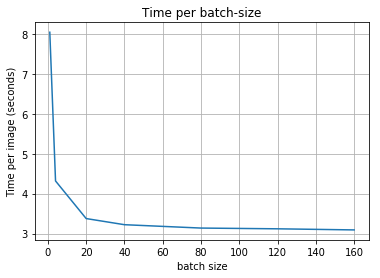

In [81]:
plt.plot([1, 4, 20, 40, 80, 120, 160], \
         [8.049812316894531, \
          4.318637907505035, \
          3.3753127574920656, \
          3.2212302148342133, \
          3.1367027908563614, \
          3.1181362926959992, \
          3.090312175452709], '-')
plt.grid()
plt.title('Time per batch-size')
plt.xlabel('batch size')
plt.ylabel('Time per image (seconds)')

In [70]:
?plt.plot